In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
import argparse
import os
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
# from pytorch_lightning.callbacks import ModelCheckpoint

from PIL import Image
from torchvision import transforms
from multimodal.multimodal_data_module import EVAL_DATA_DIR, SOS_TOKEN_ID, EOS_TOKEN_ID, IMAGE_H, IMAGE_W
from multimodal.multimodal_saycam_data_module import MultiModalSAYCamDataModule, EXTRACTED_FRAMES_DIRNAME
from multimodal.coco_captions_data_module import COCOCaptionsDataModule
# from multimodal.multimodal import MultiModalModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.attention_maps import gradCAM, getAttMap, n_inv, imshow
from train import _setup_parser

EVAL_FRAMES_DIRNAME = EVAL_DATA_DIR / "eval"

%matplotlib inline
import matplotlib.pyplot as plt

fig_sz = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

spatial_embedding_checkpoints = [
    "/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal/checkpoints/multimodal-epoch=99.ckpt",
    "checkpoints/multimodal_embedding_type_spatial_text_encoder_embedding_batch_size_16/epoch=90.ckpt",
    "checkpoints/multimodal_embedding_dim_512_batch_size_8_lr_0.0003/epoch=99.ckpt",

    "checkpoints/multimodal_sim_mean_embedding_type_spatial_text_encoder_embedding_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_False_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.0003_weight_decay_0.0_val_batch_size_16_seed_0/last.ckpt",
]

checkpoints = [
    "checkpoints/multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8",
    "checkpoints/multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8/epoch=199.ckpt",
    "checkpoints/multimodal_text_encoder_embedding_lr_0.0001_weight_decay_0.1_fix_temperature_True_batch_size_16",

    "checkpoints/multimodal_dataset_saycam_captioning_False_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/last.ckpt",
    "checkpoints/multimodal_dataset_saycam_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_fix_temperature_True_temperature_0.07_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.05_eval_include_sos_eos_True_seed_0/epoch=80.ckpt",
]
checkpoint = Path(checkpoints[-1])
if checkpoint.is_dir():
    checkpoint = list(checkpoint.glob("epoch=*.ckpt"))[0]
print("loading model from", checkpoint)
model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
model.eval()
print(model.hparams["args"])

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


loading model from checkpoints/multimodal_dataset_saycam_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_fix_temperature_True_temperature_0.07_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.05_eval_include_sos_eos_True_seed_0/epoch=80.ckpt
Namespace(logger=True, checkpoint_callback=True, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=None, gradient_clip_algorithm=None, process_position=0, num_nodes=1, num_processes=1, devices=None, gpus=1, auto_select_gpus=False, tpu_cores=None, ipus=None, log_gpu_memory=None, progress_bar_refresh_rate=None, enable_progress_bar=True, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=None, max_epochs=200, min_epochs=None, max_steps=-1, min_steps=None, max_time=None, limit_train_batches=1.0, limit_val_batches=1.0, limit_test_batches=1.0, limit_predict_batches=1.0, val_check_interval=1.0, flush_logs_every_n_steps=None, log_every_n_steps=50, accele

In [3]:
# parse empty args
parser = _setup_parser()
args = parser.parse_args("")
# set args
for key, value in model.args.items():
    setattr(args, key, value)
# make the train dataloader deterministic
args.augment_frames = False

# build data module
dataset_name = getattr(args, "dataset", "saycam")
DataModuleClass = {
    "saycam": MultiModalSAYCamDataModule,
    "coco": COCOCaptionsDataModule,
}[dataset_name]
data = DataModuleClass(args)
data.prepare_data()
data.setup()

vocab = data.read_vocab()
idx2word = {v: k for k, v in vocab.items()}

# eval datasets
eval_dev_dataset = data.eval_datasets["val"]
eval_test_dataset = data.eval_datasets["test"]

# dataloaders
eval_dev_dataloader = data.val_dataloader()[1]
eval_test_dataloader = data.test_dataloader()[1]

Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created . Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created . Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!


/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: ball
normalizing:
min: -0.0013148715
max: 0.009677261
normalizing:
min: -0.0012327564
max: 0.01014592
normalizing:
min: -0.00033110686
max: 0.0037805932
normalizing:
min: -0.0006035149
max: 0.0050376705


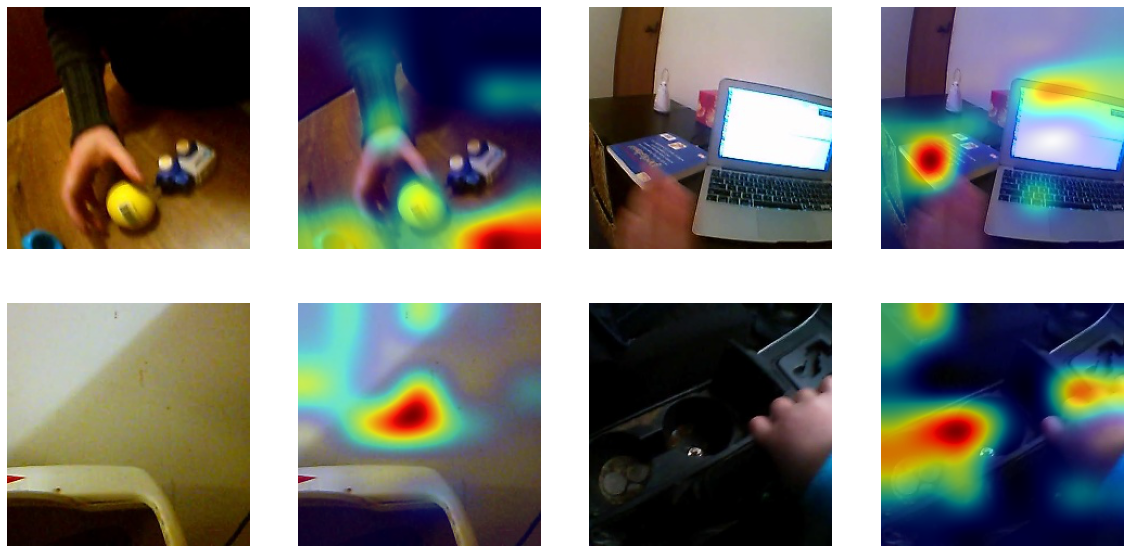

In [4]:
label_t = 1 if args.eval_include_sos_eos else 0


def encode_text(label, label_len):
    text_features = model.model.encode_text(label.unsqueeze(0).to(device), label_len.unsqueeze(0).to(device))[0]
    if model.model.normalize_features:
        text_features = F.normalize(text_features, p=2, dim=-1)
    return text_features


def get_match(img_embed, text_embed, normalize=False):
    match_sum = torch.einsum('iehw,tle->ithw', [img_embed, text_embed])  # calculate matchmap
    match = match_sum / match_sum.size(1)
    match = match[0, label_t]
    if normalize:
        match = F.normalize(match)
    return match


def show_match_heatmap(ax, img: np.ndarray, match: torch.Tensor, alpha=0.75, vmin=None, vmax=None):
    ax.imshow(img)

    import cv2
    curr_heatmap = cv2.resize(match.cpu().detach().numpy(), (IMAGE_W, IMAGE_H), interpolation=cv2.INTER_CUBIC)

    if vmin is None:
        vmin = match.min().item()
    if vmax is None:
        vmax = match.max().item()

    ax.imshow(curr_heatmap, alpha=alpha, vmin=vmin, vmax=vmax)

    ax.axis("off")


def show_heatmap(ax, np_img: np.ndarray, img: torch.Tensor, text_features: torch.Tensor, normalize=False, alpha=0.75, vmin=None, vmax=None):
    img = img.unsqueeze(0).to(device)

    if args.embedding_type == "spatial":
        image_features = model.model.encode_image(img)
        if model.model.normalize_features:
            image_features = F.normalize(image_features, p=2, dim=1)

        # calculate matchmap
        match = get_match(image_features, text_features, normalize=normalize)

        show_match_heatmap(ax, np_img, match, alpha=alpha, vmin=vmin, vmax=vmax)

    else:
        saliency_layer = "layer4"

        attn_map = gradCAM(
            model.vision_encoder.model,
            img,
            text_features,
            getattr(model.vision_encoder.model, saliency_layer),
            normalize_features=model.model.normalize_features,
        )
        attn_map = attn_map.squeeze().detach().cpu().numpy()

        attn_map = getAttMap(np_img, attn_map)
        imshow(ax, attn_map)


def get_n_rows(n_items, n_cols):
    return (n_items - 1) // n_cols + 1


# load a single example
#imgs, label, label_len, raw_label = next(iter(eval_dev_dataloader))
imgs, label, label_len, raw_label = eval_dev_dataset[[29, 101][0]]
label_len = torch.tensor(label_len)
print("label:", raw_label[0])

# display images
if imgs.dim() == 5:
    imgs = imgs.squeeze(0)
original_imgs = n_inv(imgs)

# extract first image from each batch
n_cols = 4
n_rows = get_n_rows(len(original_imgs) * 2, n_cols)
plt.figure(figsize=(fig_sz * n_cols, fig_sz * n_rows))

text_features = encode_text(label, label_len)

for i, (original_img, img) in enumerate(zip(original_imgs, imgs)):
    np_img = original_img.permute((1, 2, 0)).cpu().numpy()

    ax = plt.subplot(n_rows, n_cols, i * 2 + 1)
    imshow(ax, np_img)

    ax = plt.subplot(n_rows, n_cols, i * 2 + 2)
    show_heatmap(ax, np_img, img, text_features, normalize=True)

#plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ball')

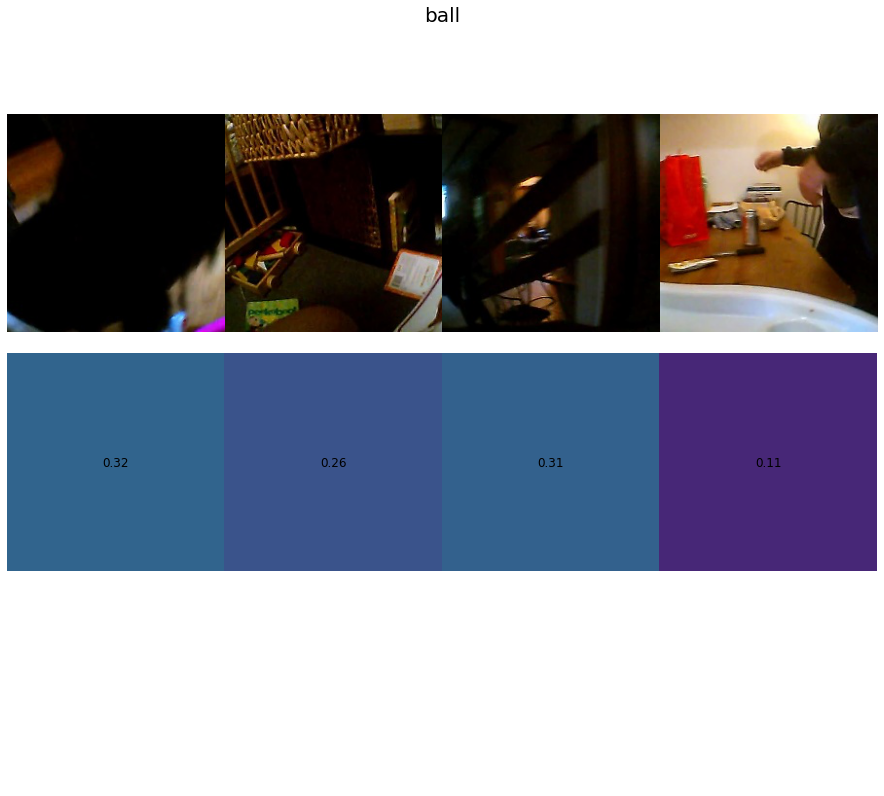

In [5]:
# eval trial
accuracy = 0
# for i in range(100):
imgs, label, label_len, raw_label = eval_dev_dataset[10]
label_len = torch.tensor(label_len)

# move to gpu
imgs = imgs.to(device)
label = label.to(device).unsqueeze(0)
label_len = label_len.to(device).unsqueeze(0)

# reshape imgs along batch dim
imgs = imgs.view(-1, *imgs.shape[-3:])

# calculate accuracy
logits_per_image, logits_per_text = model(imgs, label, label_len)
logits = logits_per_text[0]  # get logits per trial
probs = F.softmax(logits.detach(), dim=0).unsqueeze(0).cpu().numpy()
pred = torch.argmax(logits).item()
correct_label = 0  # correct answer is always the first item
accuracy += int(pred == correct_label)

# display images
inv_imgs = n_inv(imgs.squeeze(0))

count = 1
plt.figure(figsize=(20, 14))
plt.imshow(probs, vmin=0.0, vmax=1.0)
# plt.colorbar()
plt.yticks([0, 1, 2, 3], raw_label[0], fontsize=18)
plt.xticks([])
for i, image in enumerate(inv_imgs):
    image = image.permute((1, 2, 0)).detach().cpu().numpy()
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(probs.shape[1]):
    for y in range(probs.shape[0]):
        plt.text(x, y, f"{probs[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, 4 - 0.5])
plt.ylim([1 + 0.5, -2])
plt.xticks([])
plt.yticks([])
plt.title(raw_label[0], size=20)

In [6]:
# validation set visualizations

def get_captions(labels, label_len):
    captions = []
    for i in range(len(labels)):
        label = labels[i][:label_len[i]][1:-1].cpu().numpy()
        caption = [idx2word[j] for j in label]
        caption = ' '.join(caption)
        captions.append(caption)
    return captions

train_dataloader = iter(data.train_dataloader(batch_size=8, shuffle=True))

Text(0.5, 1.0, 'Cosine similarity between text and image features')

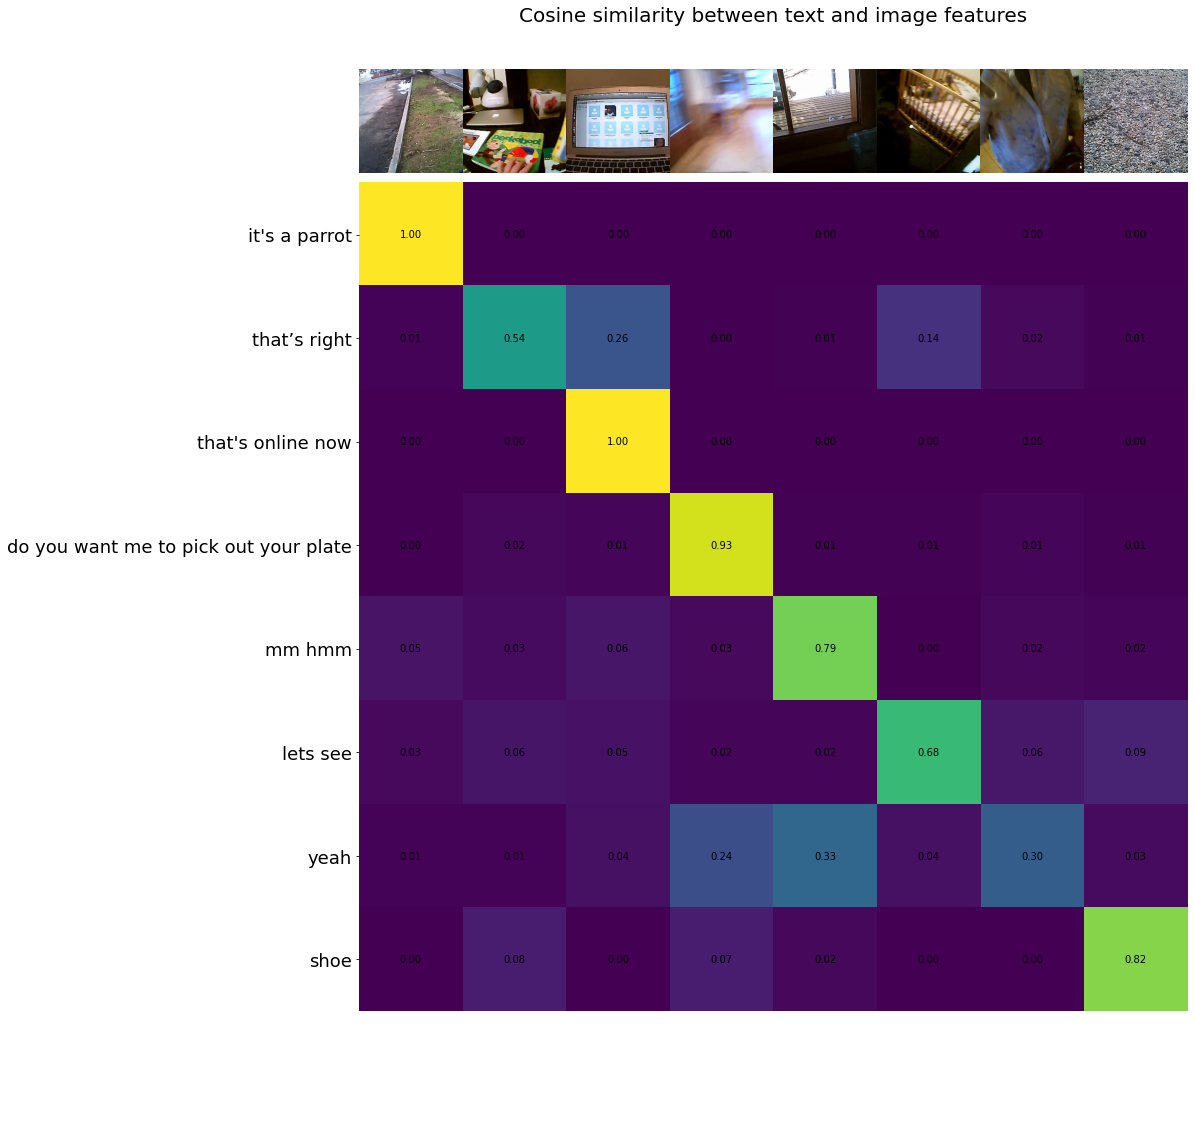

In [7]:
x, y, y_len, raw_y = train_dataloader.next()
x = x.to(device)
y = y.to(device)
y_len = y_len.to(device)
similarity, _ = model(x, y, y_len)
similarity = F.softmax(similarity, dim=1).detach().cpu().numpy()
captions = get_captions(y, y_len)

count = len(captions)
images = n_inv(x)

plt.figure(figsize=(20, 20))
plt.imshow(similarity, vmin=0.0, vmax=1.0)
# plt.colorbar()
plt.yticks(range(count), captions, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    image = image.permute((1, 2, 0)).detach().cpu().numpy()
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=10)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [8]:
# semantic search engine

# get embeddings by iterating through dataloader once
image_embeddings = []
for imgs, labels, labels_len, raw_labels in data.val_dataloader(batch_size=64, shuffle=False, drop_last=True)[0]:
    image_features = model.model.encode_image(imgs.to(device))
    image_embeddings.extend(image_features)
image_embeddings = torch.stack(image_embeddings).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.00051426294
max: 0.0036203829
normalizing:
min: -0.00046833936
max: 0.006774555
normalizing:
min: -0.0005401781
max: 0.005908757
normalizing:
min: -0.00049758755
max: 0.0075801117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.00033585704
max: 0.0045812097
normalizing:
min: -0.0006447509
max: 0.006794448
normalizing:
min: -0.0005639838
max: 0.0095325485
normalizing:
min: -0.000755034
max: 0.011960035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.0006816558
max: 0.005266579
normalizing:
min: -0.00070079596
max: 0.006645055


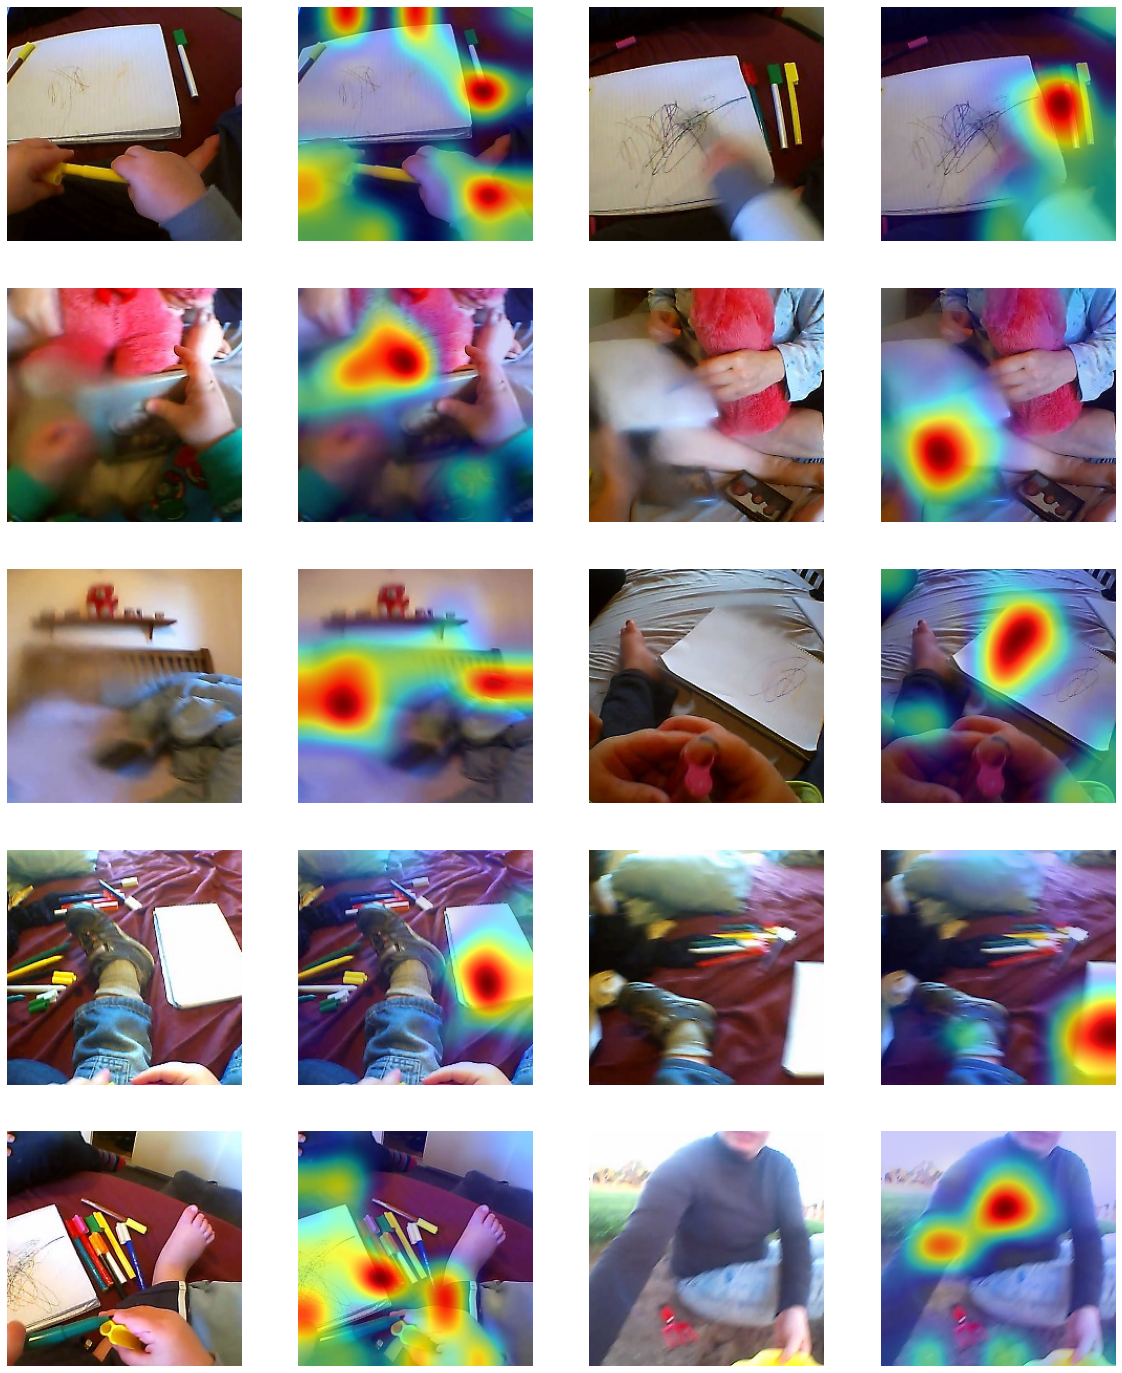

In [9]:
def get_label_embedding(raw_label):
    label = [vocab[raw_label]]
    if args.eval_include_sos_eos:
        label = [SOS_TOKEN_ID] + label + [EOS_TOKEN_ID]
    label = torch.LongTensor(label)
    label_len = len(label)
    label_len = torch.tensor(label_len)
    return encode_text(label, label_len)


# get text embedding
query = "draw"
if query is None:
    query = input("query word: ")
text_embed = get_label_embedding(query)

# calculate similarities and retrieve top k indices (k = 20)
if args.embedding_type == "spatial":
    sims = torch.einsum('iehw,tle->it', [image_embeddings, text_embed])[:, label_t]
else:
    sims = torch.einsum('ie,te->it', [image_embeddings, text_embed]).squeeze(1)
k = 10
values, indices = torch.topk(sims, k=k)

# plot results
n_cols = 4
n_rows = get_n_rows(k * 2, n_cols)
plt.figure(figsize=(fig_sz * n_cols, fig_sz * n_rows))
dataset = data.datasets["val"]
for plt_cnt, idx in enumerate(indices):
    # get frame
    frame_filename = dataset.data[idx]["frame_filenames"][0]
    original_img = Image.open(EXTRACTED_FRAMES_DIRNAME / frame_filename)
    np_img = np.array(original_img, dtype=np.float32) / 255
    img = data.base_transform(original_img)

    ax = plt.subplot(n_rows, n_cols, plt_cnt * 2 + 1)
    imshow(ax, original_img)

    ax = plt.subplot(n_rows, n_cols, plt_cnt * 2 + 2)
    show_heatmap(ax, np_img, img, text_embed, alpha=0.7)#, vmin=0, vmax=300)

1: 15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.00050216966
max: 0.0060376674
normalizing:
min: -0.00050216966
max: 0.0060376674
normalizing:
min: -0.00037542416
max: 0.005827167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.0005146352
max: 0.008851858
normalizing:
min: -0.00043761486
max: 0.0061297403


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.00017656096
max: 0.0037450625
normalizing:
min: -0.00028768752
max: 0.0033430485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.00038730906
max: 0.0044267005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.000324113
max: 0.006497528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.00044630497
max: 0.0040591797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.0007025283
max: 0.00442047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.0006020956
max: 0.0053294254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.0004236795
max: 0.006457332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.00042993086
max: 0.0064169825


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.00049283955
max: 0.007975846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normalizing:
min: -0.0005310172
max: 0.0056064157


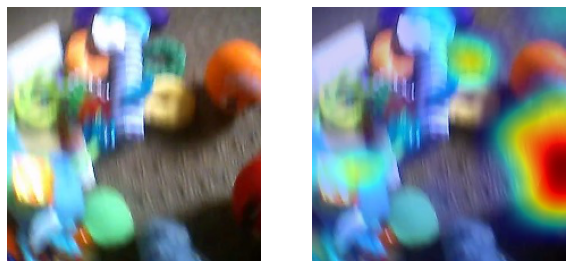

In [10]:
# frame animation
from matplotlib.animation import FuncAnimation

# get text features
query = "ball"
if query is None:
    query = input("query word: ")
text_embed = get_label_embedding(query)

i = 1
single_img_filenames = [x for x in dataset.data if query in x['utterance']][i]["frame_filenames"]
print(f'{i}: {len(single_img_filenames)}')

n_cols = 2
n_rows = 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_sz * n_cols, fig_sz * n_rows))

def animate(frame_num):
    frame_filename = single_img_filenames[frame_num]
    original_img = Image.open(EXTRACTED_FRAMES_DIRNAME / frame_filename)
    np_img = np.array(original_img, dtype=np.float32) / 255
    img = dataset.transform(original_img)

    imshow(axs[0], original_img)
    show_heatmap(axs[1], np_img, img, text_embed, alpha=0.7)#, vmin=-20, vmax=60)

anim = FuncAnimation(fig, animate, frames=len(single_img_filenames), interval=200)
# anim.save('ball-4.mp4', writer='ffmpeg', fps=5, dpi=100)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [11]:
# copying eval.py code

use_kitty_label = False

# create dataloader
eval_dataloader = data.val_dataloader()[1]

# get eval categories
classes = sorted(os.listdir(EVAL_FRAMES_DIRNAME / "dev"))
classes.remove("carseat")
classes.remove("couch")
classes.remove("greenery")
classes.remove("plushanimal")

# replace cat with kitty
if use_kitty_label:
    classes.remove("cat")
    classes.append("kitty")

# initialize correct and total pred counts
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# initialize results
results = []

# get model predictions
for i, batch in enumerate(eval_dataloader):
    img, label, label_len, raw_label = batch

    # get text category label
    class_label = raw_label[0][0]

    if use_kitty_label and class_label == "cat":
        # use kitty for cat eval
        class_label = "kitty"
        label = [vocab[class_label]]
        if args.eval_include_sos_eos:
            label = [SOS_TOKEN_ID] + label + [EOS_TOKEN_ID]
        label = torch.LongTensor([label])

    img = img.squeeze(0).to(device)  # remove outer batch
    label = label.to(device)
    label_len = label_len.to(device)

    # calculate similarity between images
    # first, get embeddings
    with torch.no_grad():
        _, logits_per_text = model(img, label, label_len)
        logits_list = torch.softmax(logits_per_text,
                                    dim=-1).detach().cpu().numpy().tolist()[0]
        pred = torch.argmax(logits_per_text, dim=-1).item()
        ground_truth = 0

    # second, calculate if correct referent is predicted
    correct = False
    if pred == ground_truth:
        correct = True
        correct_pred[class_label] += 1

    total_pred[class_label] += 1

    # store results
    curr_results = [i, class_label, correct] + logits_list
    results.append(curr_results)

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname:8s} is: {accuracy:.1%}")

# print total accuracy
total_correct = sum(correct_pred.values())
total = sum(total_pred.values())
print(f"Total accuracy: {total_correct / total:%}")

Accuracy for class ball     is: 58.0%
Accuracy for class basket   is: 22.0%
Accuracy for class car      is: 66.0%
Accuracy for class cat      is: 30.0%
Accuracy for class chair    is: 61.0%
Accuracy for class computer is: 68.0%
Accuracy for class crib     is: 84.0%
Accuracy for class door     is: 45.0%
Accuracy for class floor    is: 34.0%
Accuracy for class foot     is: 39.0%
Accuracy for class ground   is: 48.0%
Accuracy for class hand     is: 20.0%
Accuracy for class kitchen  is: 59.0%
Accuracy for class paper    is: 85.0%
Accuracy for class puzzle   is: 80.0%
Accuracy for class road     is: 74.0%
Accuracy for class room     is: 35.0%
Accuracy for class sand     is: 92.0%
Accuracy for class stairs   is: 78.0%
Accuracy for class table    is: 70.0%
Accuracy for class toy      is: 37.0%
Accuracy for class window   is: 61.0%
Total accuracy: 56.636364%


Text(0, 0.5, 'Evaluation Accuracy')

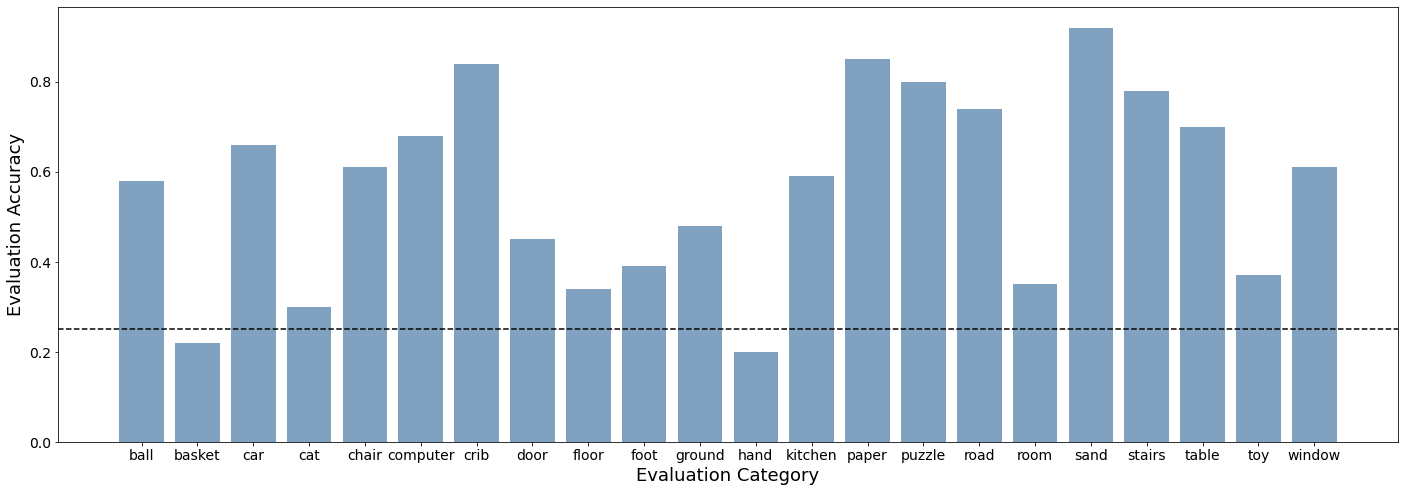

In [12]:
categories = correct_pred.keys()
accuracy = [float(correct_count) / total_pred[classname] for classname, correct_count in correct_pred.items()]
cm = plt.get_cmap('Pastel1', len(categories))
cm

plt.figure(figsize=(24, 8))
plt.bar(categories, accuracy, color="#81A1C1")
plt.axhline(y=0.25, linestyle='--', color="black")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Evaluation Category", fontsize=18)
plt.ylabel("Evaluation Accuracy", fontsize=18)